In [259]:
import pandas as pd
from holidays import UnitedStates
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import calendar
import scipy.stats as stats

# Datasets Reading

In [260]:
taxi_df = pd.read_csv("dataset.csv", index_col=0)
# Create a new row for 2015-02-01 00:00:00
new_row = {'timestamp': pd.Timestamp('2015-02-01 00:00:00'), 'value': np.nan}

# Append the new row to the original DataFrame
taxi_df.loc[len(taxi_df)] = new_row
taxi_df

,timestamp,value
0,2014-07-01 00:00:00,10844.0
1,2014-07-01 00:30:00,8127.0
2,2014-07-01 01:00:00,6210.0
3,2014-07-01 01:30:00,4656.0
4,2014-07-01 02:00:00,3820.0
...,...,...
10316,2015-01-31 22:00:00,25721.0
10317,2015-01-31 22:30:00,27309.0
10318,2015-01-31 23:00:00,26591.0
10319,2015-01-31 23:30:00,26288.0


In [261]:
print(taxi_df.isnull().sum())
taxi_df.info()

timestamp    0
value        1
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 10321 entries, 0 to 10320
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  10321 non-null  object 
 1   value      10320 non-null  float64
dtypes: float64(1), object(1)
memory usage: 241.9+ KB


In [262]:
weather_df = pd.read_csv('weather_csv.csv')
weather_df.head()

,timestamp,prep,snow,snow_depth,min_temp,max_temp
0,2014-07-01,0.00,0.0,0.0,72.0,89.0
1,2014-07-02,0.96,0.0,0.0,72.0,91.0
2,2014-07-03,1.78,0.0,0.0,69.0,87.0
3,2014-07-04,0.14,0.0,0.0,65.0,74.0
4,2014-07-05,0.00,0.0,0.0,63.0,81.0


In [263]:
print(weather_df.isnull().sum())
weather_df.info()

timestamp     0
prep          0
snow          0
snow_depth    0
min_temp      0
max_temp      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   216 non-null    object 
 1   prep        216 non-null    float64
 2   snow        216 non-null    float64
 3   snow_depth  216 non-null    float64
 4   min_temp    216 non-null    float64
 5   max_temp    216 non-null    float64
dtypes: float64(5), object(1)
memory usage: 10.3+ KB


In [264]:
# Create a holiday object for the US with state-specific holidays for New York
ny_holidays = UnitedStates(years=[2014, 2015], state='NY')

# Convert to a DataFrame
holidays_df = pd.DataFrame({
    "Date": list(ny_holidays.keys()),
    "Holiday": list(ny_holidays.values())
})

# Convert 'Date' to datetime
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

# Filter holidays up to '2015-01-31'
holidays_df = holidays_df.loc[(holidays_df['Date'] <= '2015-01-31') & (holidays_df['Date'] >= '2014-07-01')]

# Sort by index and rename the column "Date" to "timestamp"
holidays_df = holidays_df.sort_values(by=['Date'])

# Show the final DataFrame
holidays_df

,Date,Holiday
2,2014-07-04,Independence Day
3,2014-09-01,Labor Day
9,2014-10-13,Columbus Day
12,2014-11-04,Election Day
4,2014-11-11,Veterans Day
5,2014-11-27,Thanksgiving
6,2014-12-25,Christmas Day
13,2015-01-01,New Year's Day
21,2015-01-19,Martin Luther King Jr. Day


In [265]:
taxi_df['timestamp'] = pd.to_datetime(taxi_df['timestamp'])
taxi_df['year'] = taxi_df['timestamp'].dt.year
taxi_df['month'] = taxi_df['timestamp'].dt.month
taxi_df['day'] = taxi_df['timestamp'].dt.day
taxi_df['Date'] = taxi_df['timestamp'].dt.date
taxi_df['Date'] = taxi_df['Date'].apply(pd.to_datetime).dt.date
taxi_df['day_of_week'] = taxi_df['timestamp'].dt.day_of_week + 1
taxi_df['hour'] = taxi_df['timestamp'].dt.hour
taxi_df['isWeekend'] = taxi_df.day_of_week.map({1: False, 2: False, 3: False, 4: False, 5: False, 6: True, 7: True})
taxi_df['day_of_week'] = taxi_df['day_of_week'].map({1: 'Monday', 2:'Tuesday'
                                                     , 3:'Wednesday', 4:"Thursday", 5: 'Friday',
                                                     6: 'Saturday', 7: 'Sunday'})

# Add time parts to the anomaly dates and update the 'isAnomaly' column
taxi_df['isAnomaly'] = False
anomaly_dates = ['2014-11-02', '2014-11-27', '2014-12-24', '2014-12-25', '2015-01-01', '2015-01-26', '2015-01-27']

anomaly_dates = [pd.to_datetime(date).date() for date in anomaly_dates]
taxi_df['isAnomaly'] = taxi_df['Date'].isin(anomaly_dates)

# View the dataset for verification
taxi_df.loc[taxi_df['isAnomaly']][['Date', 'isAnomaly']]

,Date,isAnomaly
5952,2014-11-02,True
5953,2014-11-02,True
5954,2014-11-02,True
5955,2014-11-02,True
5956,2014-11-02,True
...,...,...
10123,2015-01-27,True
10124,2015-01-27,True
10125,2015-01-27,True
10126,2015-01-27,True


In [266]:
taxi_df

,timestamp,value,year,month,day,Date,day_of_week,hour,isWeekend,isAnomaly
0,2014-07-01 00:00:00,10844.0,2014,7,1,2014-07-01,Tuesday,0,False,False
1,2014-07-01 00:30:00,8127.0,2014,7,1,2014-07-01,Tuesday,0,False,False
2,2014-07-01 01:00:00,6210.0,2014,7,1,2014-07-01,Tuesday,1,False,False
3,2014-07-01 01:30:00,4656.0,2014,7,1,2014-07-01,Tuesday,1,False,False
4,2014-07-01 02:00:00,3820.0,2014,7,1,2014-07-01,Tuesday,2,False,False
...,...,...,...,...,...,...,...,...,...,...
10316,2015-01-31 22:00:00,25721.0,2015,1,31,2015-01-31,Saturday,22,True,False
10317,2015-01-31 22:30:00,27309.0,2015,1,31,2015-01-31,Saturday,22,True,False
10318,2015-01-31 23:00:00,26591.0,2015,1,31,2015-01-31,Saturday,23,True,False
10319,2015-01-31 23:30:00,26288.0,2015,1,31,2015-01-31,Saturday,23,True,False


Merging datasets

In [267]:
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])
taxi_df['Date'] = pd.to_datetime(taxi_df['Date'])
merged_data = pd.merge(taxi_df, holidays_df, how='left', on='Date')

weather_df['timestamp'] = weather_df['timestamp'] + ' 00:00:00'
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'] + ' 00:00:00')
weather_df['timestamp'] = weather_df['timestamp'].dt.normalize()
weather_df
merged_data = pd.merge(merged_data, weather_df, how='left', on='timestamp')
merged_data.loc[~merged_data['Holiday'].isnull()]

C:\Users\weare\AppData\Local\Temp\ipykernel_12792\2614963403.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'] + ' 00:00:00')


,timestamp,value,year,month,day,Date,day_of_week,hour,isWeekend,isAnomaly,Holiday,prep,snow,snow_depth,min_temp,max_temp
144,2014-07-04 00:00:00,15591.0,2014,7,4,2014-07-04,Friday,0,False,False,Independence Day,0.14,0.0,0.0,65.0,74.0
145,2014-07-04 00:30:00,14395.0,2014,7,4,2014-07-04,Friday,0,False,False,Independence Day,NaN,NaN,NaN,NaN,NaN
146,2014-07-04 01:00:00,12535.0,2014,7,4,2014-07-04,Friday,1,False,False,Independence Day,NaN,NaN,NaN,NaN,NaN
147,2014-07-04 01:30:00,11341.0,2014,7,4,2014-07-04,Friday,1,False,False,Independence Day,NaN,NaN,NaN,NaN,NaN
148,2014-07-04 02:00:00,9980.0,2014,7,4,2014-07-04,Friday,2,False,False,Independence Day,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9739,2015-01-19 21:30:00,14069.0,2015,1,19,2015-01-19,Monday,21,False,False,Martin Luther King Jr. Day,NaN,NaN,NaN,NaN,NaN
9740,2015-01-19 22:00:00,13506.0,2015,1,19,2015-01-19,Monday,22,False,False,Martin Luther King Jr. Day,NaN,NaN,NaN,NaN,NaN
9741,2015-01-19 22:30:00,12936.0,2015,1,19,2015-01-19,Monday,22,False,False,Martin Luther King Jr. Day,NaN,NaN,NaN,NaN,NaN
9742,2015-01-19 23:00:00,10400.0,2015,1,19,2015-01-19,Monday,23,False,False,Martin Luther King Jr. Day,NaN,NaN,NaN,NaN,NaN


In [268]:
dataset = merged_data.copy()
dataset

,timestamp,value,year,month,day,Date,day_of_week,hour,isWeekend,isAnomaly,Holiday,prep,snow,snow_depth,min_temp,max_temp
0,2014-07-01 00:00:00,10844.0,2014,7,1,2014-07-01,Tuesday,0,False,False,NaN,0.00,0.0,0.0,72.0,89.0
1,2014-07-01 00:30:00,8127.0,2014,7,1,2014-07-01,Tuesday,0,False,False,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-07-01 01:00:00,6210.0,2014,7,1,2014-07-01,Tuesday,1,False,False,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-07-01 01:30:00,4656.0,2014,7,1,2014-07-01,Tuesday,1,False,False,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-07-01 02:00:00,3820.0,2014,7,1,2014-07-01,Tuesday,2,False,False,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10316,2015-01-31 22:00:00,25721.0,2015,1,31,2015-01-31,Saturday,22,True,False,NaN,NaN,NaN,NaN,NaN,NaN
10317,2015-01-31 22:30:00,27309.0,2015,1,31,2015-01-31,Saturday,22,True,False,NaN,NaN,NaN,NaN,NaN,NaN
10318,2015-01-31 23:00:00,26591.0,2015,1,31,2015-01-31,Saturday,23,True,False,NaN,NaN,NaN,NaN,NaN,NaN
10319,2015-01-31 23:30:00,26288.0,2015,1,31,2015-01-31,Saturday,23,True,False,NaN,NaN,NaN,NaN,NaN,NaN


Filling the missing values

In [269]:
dataset = dataset[['timestamp','value','month','day','hour','day_of_week','isWeekend','isAnomaly','Holiday','prep','snow','snow_depth','min_temp','max_temp']]
dataset['isHoliday'] = False
dataset.loc[~dataset['Holiday'].isnull(),'isHoliday'] = True
dataset

C:\Users\weare\AppData\Local\Temp\ipykernel_12792\2121259570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['isHoliday'] = False


,timestamp,value,month,day,hour,day_of_week,isWeekend,isAnomaly,Holiday,prep,snow,snow_depth,min_temp,max_temp,isHoliday
0,2014-07-01 00:00:00,10844.0,7,1,0,Tuesday,False,False,NaN,0.00,0.0,0.0,72.0,89.0,False
1,2014-07-01 00:30:00,8127.0,7,1,0,Tuesday,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2014-07-01 01:00:00,6210.0,7,1,1,Tuesday,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2014-07-01 01:30:00,4656.0,7,1,1,Tuesday,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False
4,2014-07-01 02:00:00,3820.0,7,1,2,Tuesday,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10316,2015-01-31 22:00:00,25721.0,1,31,22,Saturday,True,False,NaN,NaN,NaN,NaN,NaN,NaN,False
10317,2015-01-31 22:30:00,27309.0,1,31,22,Saturday,True,False,NaN,NaN,NaN,NaN,NaN,NaN,False
10318,2015-01-31 23:00:00,26591.0,1,31,23,Saturday,True,False,NaN,NaN,NaN,NaN,NaN,NaN,False
10319,2015-01-31 23:30:00,26288.0,1,31,23,Saturday,True,False,NaN,NaN,NaN,NaN,NaN,NaN,False


In [270]:
# Save the merged_data DataFrame to a CSV file
dataset.to_csv('updated_dataset.csv', index=False)

In [271]:
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
dataset = dataset.set_index("timestamp")
print(dataset.isnull().sum())
print()
dataset.describe()

value              1
month              0
day                0
hour               0
day_of_week        0
isWeekend          0
isAnomaly          0
Holiday         9889
prep           10105
snow           10105
snow_depth     10105
min_temp       10105
max_temp       10105
isHoliday          0
dtype: int64



C:\Users\weare\AppData\Local\Temp\ipykernel_12792\1830696519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])


,value,month,day,hour,prep,snow,snow_depth,min_temp,max_temp
count,10320.000000,10321.000000,10321.000000,10321.000000,216.000000,216.000000,216.000000,216.000000,216.000000
mean,15137.569380,8.269160,15.859025,11.498886,0.141806,0.085185,0.248611,49.777778,62.995370
std,6939.495808,3.379261,8.868658,6.923112,0.366058,0.552005,1.191598,17.416823,19.140484
min,8.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.000000,21.000000
25%,10262.000000,7.000000,8.000000,5.000000,0.000000,0.000000,0.000000,35.000000,44.750000
50%,16778.000000,9.000000,16.000000,11.000000,0.000000,0.000000,0.000000,52.500000,67.000000
75%,19838.750000,11.000000,24.000000,17.000000,0.060000,0.000000,0.000000,65.250000,81.000000
max,39197.000000,12.000000,31.000000,23.000000,2.540000,5.500000,7.900000,77.000000,92.000000


In [272]:
dataset

,value,month,day,hour,day_of_week,isWeekend,isAnomaly,Holiday,prep,snow,snow_depth,min_temp,max_temp,isHoliday
timestamp,,,,,,,,,,,,,,
2014-07-01 00:00:00,10844.0,7,1,0,Tuesday,False,False,NaN,0.00,0.0,0.0,72.0,89.0,False
2014-07-01 00:30:00,8127.0,7,1,0,Tuesday,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False
2014-07-01 01:00:00,6210.0,7,1,1,Tuesday,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False
2014-07-01 01:30:00,4656.0,7,1,1,Tuesday,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False
2014-07-01 02:00:00,3820.0,7,1,2,Tuesday,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-31 22:00:00,25721.0,1,31,22,Saturday,True,False,NaN,NaN,NaN,NaN,NaN,NaN,False
2015-01-31 22:30:00,27309.0,1,31,22,Saturday,True,False,NaN,NaN,NaN,NaN,NaN,NaN,False
2015-01-31 23:00:00,26591.0,1,31,23,Saturday,True,False,NaN,NaN,NaN,NaN,NaN,NaN,False


# Data Preparation & Preprocessing

In [273]:
# Perform interpolation for specific columns
columns_to_interpolate = ['prep', 'snow', 'snow_depth', 'min_temp', 'max_temp']

# Interpolate only within ranges defined by 00:00:00 timestamps
dataset[columns_to_interpolate] = dataset[columns_to_interpolate].interpolate(method='time')
# Remove the row with index '2015-02-01 00:00:00'
dataset = dataset.drop(pd.Timestamp('2015-02-01 00:00:00'))

dataset.loc[dataset['Holiday'].isnull(), 'Holiday'] = 'None' # in string
dataset["month"] = dataset["month"].apply(lambda x: calendar.month_name[x])
dataset['value'] = dataset['value'].astype(int)
dataset['range_temp'] = abs(dataset['max_temp'] - dataset['min_temp'])
dataset

,value,month,day,hour,day_of_week,isWeekend,isAnomaly,Holiday,prep,snow,snow_depth,min_temp,max_temp,isHoliday,range_temp
timestamp,,,,,,,,,,,,,,,
2014-07-01 00:00:00,10844,July,1,0,Tuesday,False,False,None,0.000000,0.00000,0.000,72.000000,89.000000,False,17.000000
2014-07-01 00:30:00,8127,July,1,0,Tuesday,False,False,None,0.020000,0.00000,0.000,72.000000,89.041667,False,17.041667
2014-07-01 01:00:00,6210,July,1,1,Tuesday,False,False,None,0.040000,0.00000,0.000,72.000000,89.083333,False,17.083333
2014-07-01 01:30:00,4656,July,1,1,Tuesday,False,False,None,0.060000,0.00000,0.000,72.000000,89.125000,False,17.125000
2014-07-01 02:00:00,3820,July,1,2,Tuesday,False,False,None,0.080000,0.00000,0.000,72.000000,89.166667,False,17.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-31 21:30:00,24670,January,31,21,Saturday,True,False,None,0.026875,0.26875,6.025,19.270833,34.958333,False,15.687500
2015-01-31 22:00:00,25721,January,31,22,Saturday,True,False,None,0.027500,0.27500,6.000,19.416667,35.166667,False,15.750000
2015-01-31 22:30:00,27309,January,31,22,Saturday,True,False,None,0.028125,0.28125,5.975,19.562500,35.375000,False,15.812500


In [274]:
print(dataset.isnull().sum())
print()
dataset.describe()

value          0
month          0
day            0
hour           0
day_of_week    0
isWeekend      0
isAnomaly      0
Holiday        0
prep           0
snow           0
snow_depth     0
min_temp       0
max_temp       0
isHoliday      0
range_temp     0
dtype: int64



,value,day,hour,prep,snow,snow_depth,min_temp,max_temp,range_temp
count,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000
mean,15137.569380,15.860465,11.500000,0.142394,0.084869,0.235761,49.797868,63.000242,13.202374
std,6939.495808,8.867881,6.922522,0.303623,0.487209,1.138648,17.166381,18.863386,4.073228
min,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.000000,21.000000,3.000000
25%,10262.000000,8.000000,5.750000,0.000000,0.000000,0.000000,34.958333,44.750000,10.348958
50%,16778.000000,16.000000,11.500000,0.007500,0.000000,0.000000,52.250000,66.416667,13.333333
75%,19838.750000,24.000000,17.250000,0.126667,0.000000,0.000000,65.484375,80.916667,16.166667
max,39197.000000,31.000000,23.000000,2.540000,5.500000,7.900000,77.000000,92.000000,28.000000


# Data Analysis

## Total taxi passengers & all the weathers features by specific times group

Variables:
- value
- prep & snow & snow_depth
- min_temp & max_temp & range_temp

Visualisations:
- Throughout all the data
- By each month
- By each day_of_week
- By each isWeekend
- Only the holidays

### Variable "value"

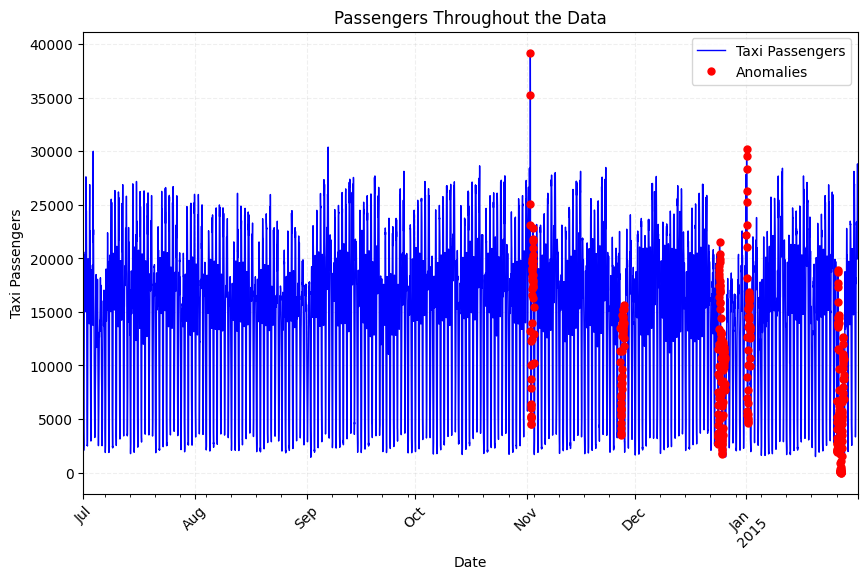

In [ ]:
def make_graph(interval=None, col = 'value'):
    # Plotting the main "value" series
    if interval is None:
        graph = dataset[col]
        anomaly = dataset.loc[dataset['isAnomaly'], col]
        title = 'Passengers Throughout the Data'
    else:
        start, end = interval  # Unpack the start and end dates
        graph = dataset.loc[start:end, col]
        anomaly = dataset.loc[
            (dataset.index >= start) & (dataset.index <= end) & (dataset['isAnomaly']),
            'value'
        ]
        title = f'Passengers from {start} to {end}'

    # Plot the main graph
    graph.plot(figsize=(10, 6), color='blue', linewidth=1, label='Taxi Passengers')

    # Plot anomalies if they exist
    if not anomaly.empty:
        anomaly.plot(
            linestyle='None',
            marker='o',
            color='red',
            markersize=5,
            label='Anomalies'
        )

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(title)

    # Rotating x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Adding a grid with some transparency
    plt.grid(True, linestyle='--', alpha=0.2)

    # Displaying the legend to differentiate the series
    plt.legend()

    # Show the plot
    plt.show()

# Throughout the data
make_graph()

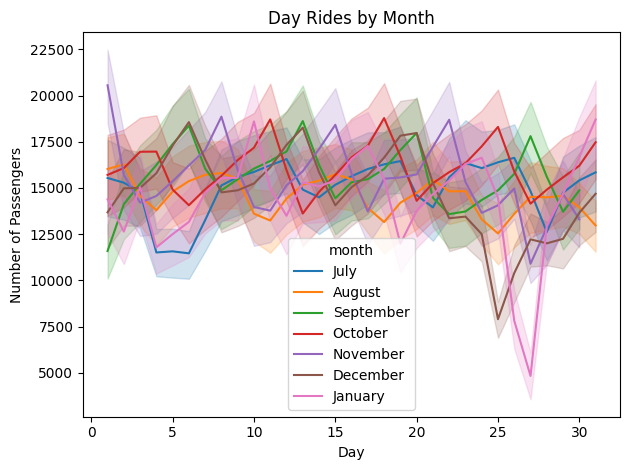

In [276]:
# By each months for every hours
sns.lineplot(
    x="day", 
    y="value",
    data=dataset,
    hue= "month")
plt.xlabel("Day")
plt.ylabel("Number of Passengers")
plt.title("Day Rides by Month")
plt.tight_layout()
plt.show()

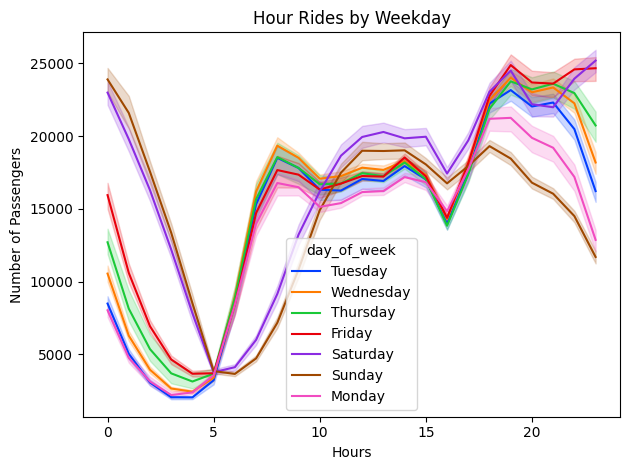

In [277]:
sns.lineplot(
    x="hour", 
    y="value",
    data=dataset,
    palette='bright',
    hue= "day_of_week")
plt.xlabel("Hours")
plt.ylabel("Number of Passengers")
plt.title("Hour Rides by Weekday")
plt.tight_layout()
plt.show()

### Variables prep & snow & snow_depth

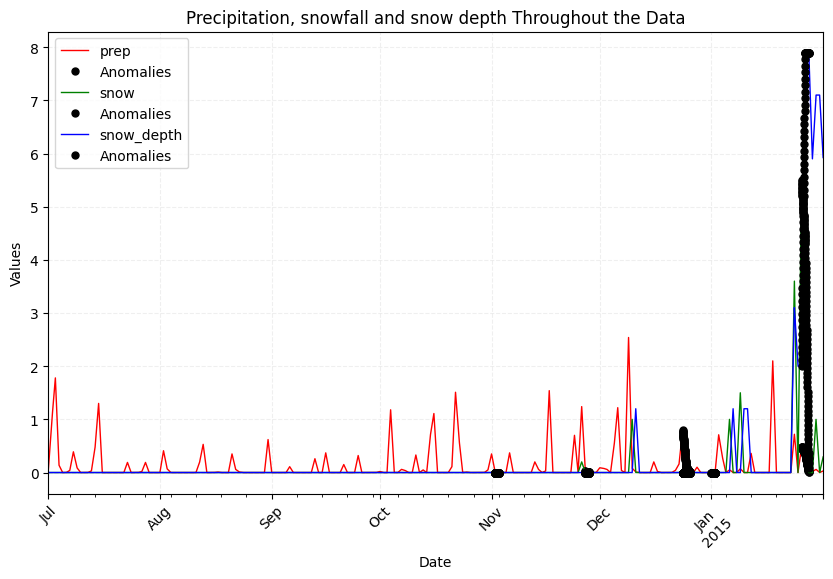

In [286]:
col_to_check = ['prep','snow','snow_depth']
graph = dataset[col_to_check]
anomaly = dataset.loc[dataset['isAnomaly'], col_to_check]
title = 'Precipitation, snowfall and snow depth Throughout the Data'
# Plot the main graph
colour = ['red','green','blue']
for ind in range(len(col_to_check)):
    graph[col_to_check[ind]].plot(figsize=(10, 6), color=colour[ind], linewidth=1, label=col_to_check[ind])
    anomaly[col_to_check[ind]].plot(linestyle='None',marker='o',color='black',markersize=5,label='Anomalies')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title(title)

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45)

# Adding a grid with some transparency
plt.grid(True, linestyle='--', alpha=0.2)

# Displaying the legend to differentiate the series
plt.legend()

# Show the plot
plt.show()

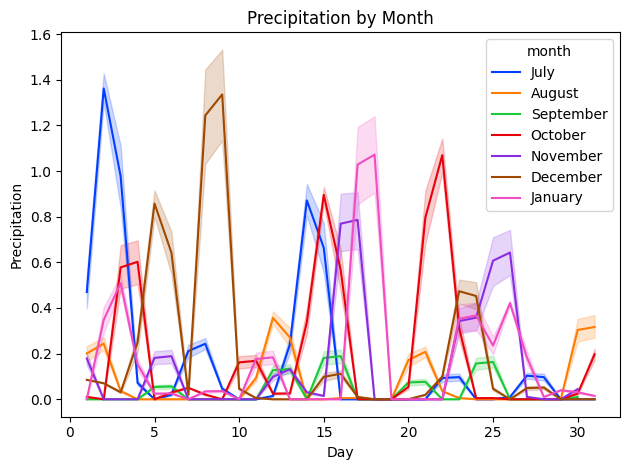

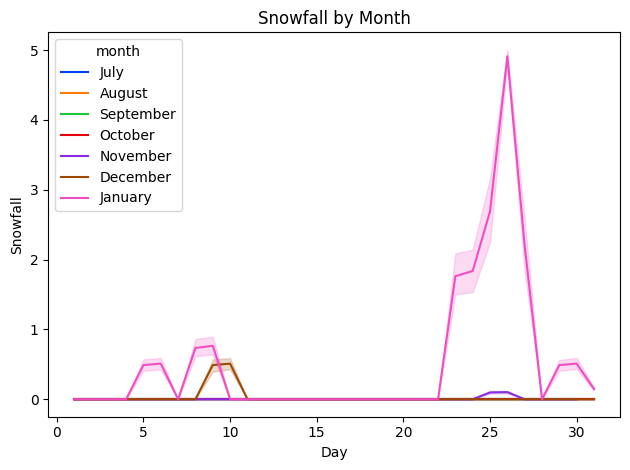

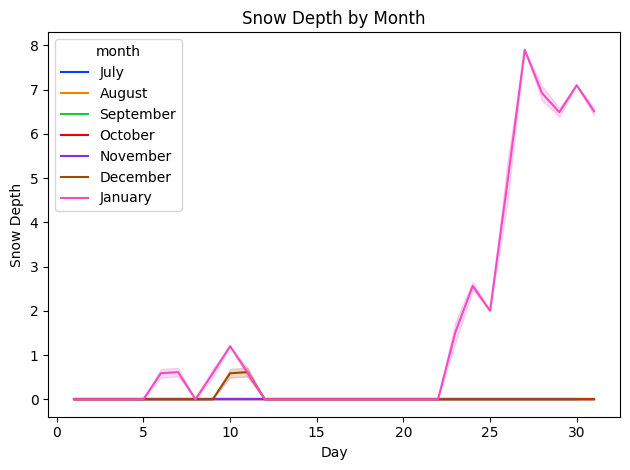

In [288]:
# By each months for every hours
title = ["Precipitation", "Snowfall", "Snow Depth"]
for ind in range(len(col_to_check)):
    sns.lineplot(
        x="day", 
        y=col_to_check[ind],
        data=dataset,
        palette='bright',
        hue= "month")
    plt.xlabel("Day")
    plt.ylabel(title[ind])
    plt.title(f"{title[ind]} by Month")
    plt.tight_layout()
    plt.show()

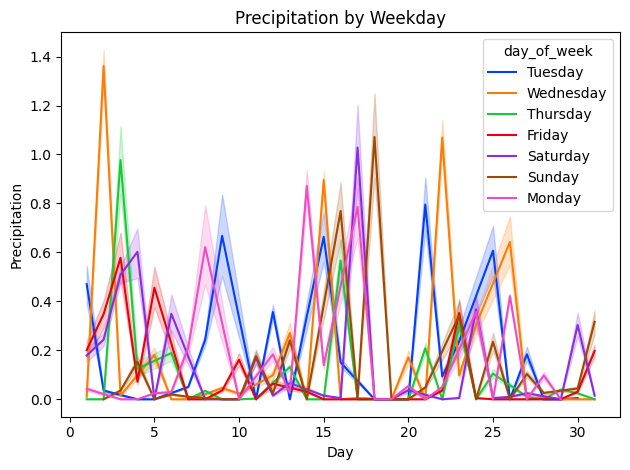

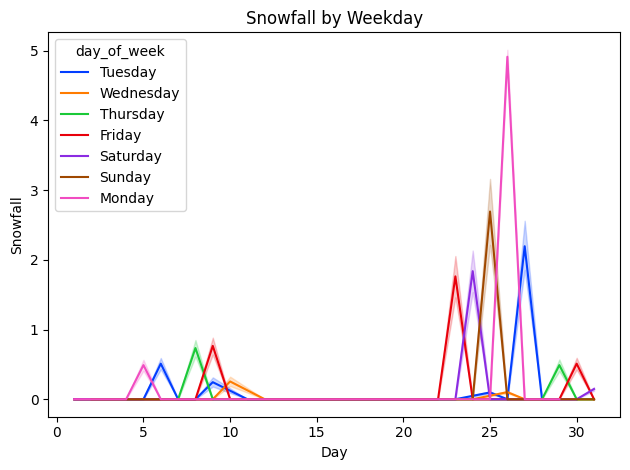

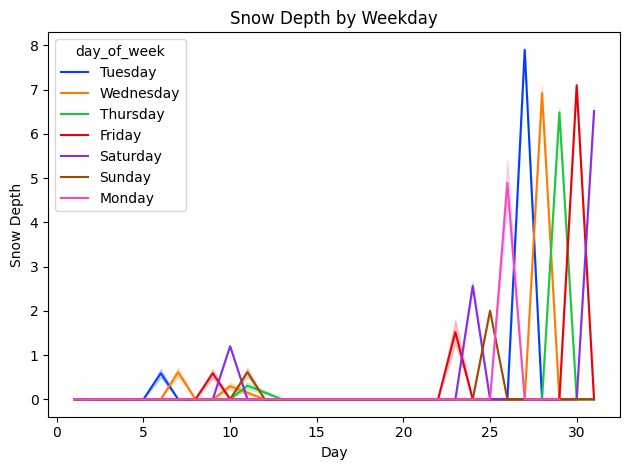

In [ ]:
# By each day_of_week
title = ["Precipitation", "Snowfall", "Snow Depth"]
for ind in range(len(col_to_check)):
    sns.lineplot(
        x="day", 
        y=col_to_check[ind],
        data=dataset,
        palette='bright',
        hue= "day_of_week")
    plt.xlabel("Day")
    plt.ylabel(title[ind])
    plt.title(f"{title[ind]} by Weekday")
    plt.tight_layout()
    plt.show()

### Variables min_temp, max_temp, range_temp

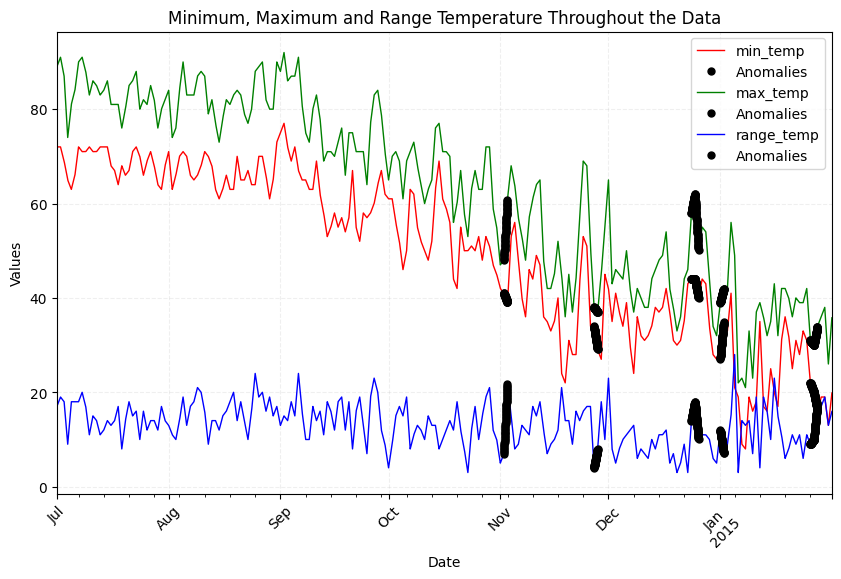

In [290]:
col_to_check = ['min_temp','max_temp','range_temp']
graph = dataset[col_to_check]
anomaly = dataset.loc[dataset['isAnomaly'], col_to_check]
title = 'Minimum, Maximum and Range Temperature Throughout the Data'
# Plot the main graph
colour = ['red','green','blue']
for ind in range(len(col_to_check)):
    graph[col_to_check[ind]].plot(figsize=(10, 6), color=colour[ind], linewidth=1, label=col_to_check[ind])
    anomaly[col_to_check[ind]].plot(linestyle='None',marker='o',color='black',markersize=5,label='Anomalies')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title(title)

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45)

# Adding a grid with some transparency
plt.grid(True, linestyle='--', alpha=0.2)

# Displaying the legend to differentiate the series
plt.legend()

# Show the plot
plt.show()

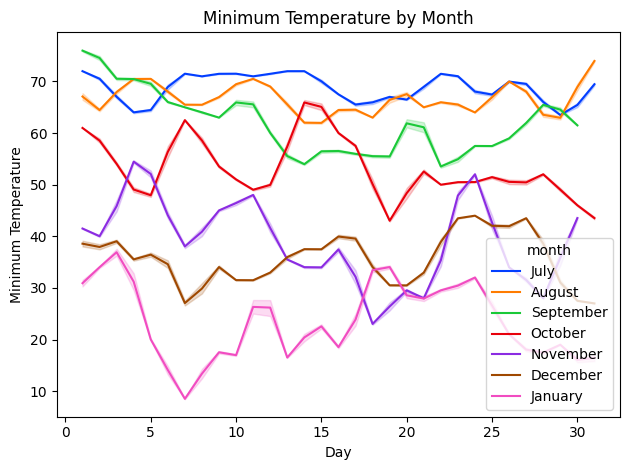

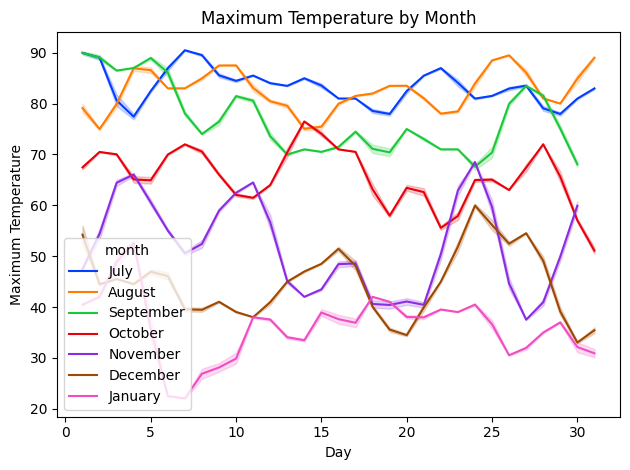

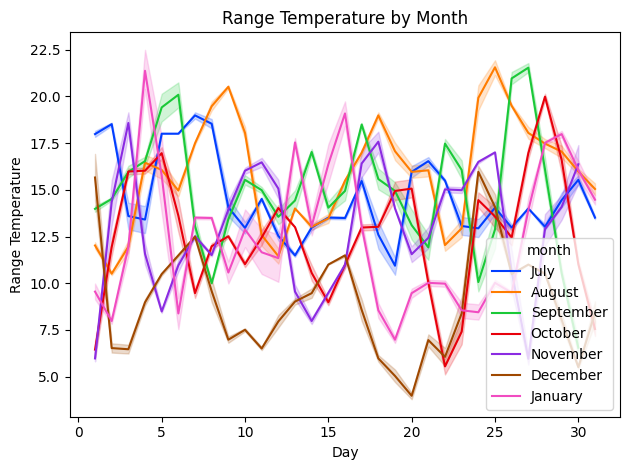

In [292]:
# By each months for every hours
title = ["Minimum Temperature", "Maximum Temperature", "Range Temperature"]
for ind in range(len(col_to_check)):
    sns.lineplot(
        x="day", 
        y=col_to_check[ind],
        data=dataset,
        palette='bright',
        hue= "month")
    plt.xlabel("Day")
    plt.ylabel(title[ind])
    plt.title(f"{title[ind]} by Month")
    plt.tight_layout()
    plt.show()

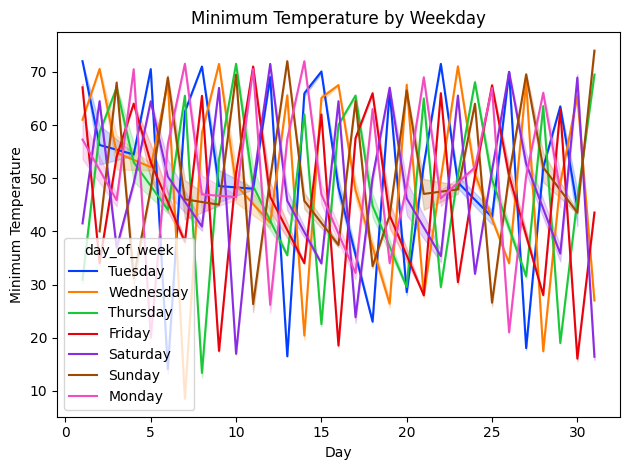

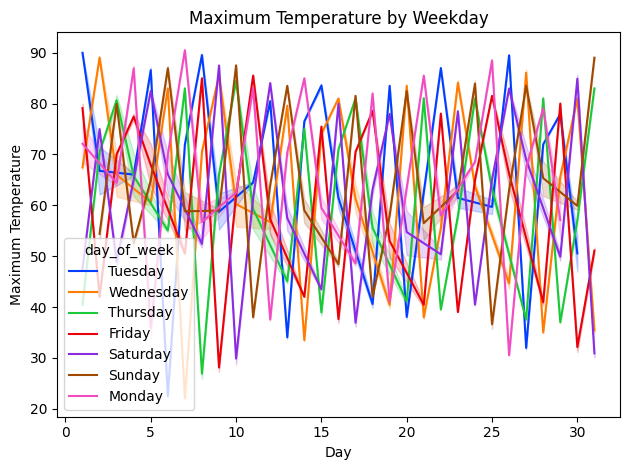

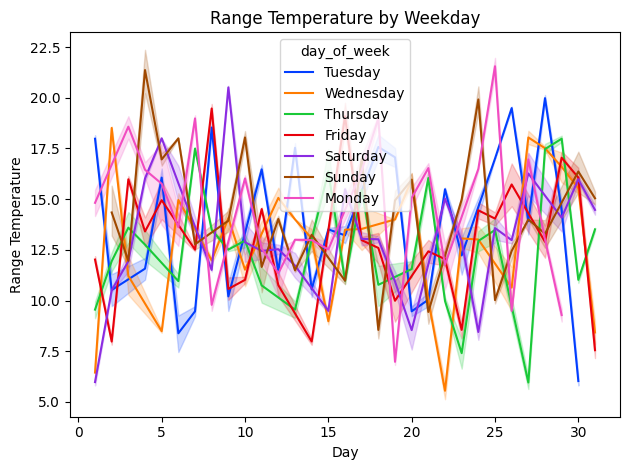

In [291]:
# By each day_of_week
title = ["Minimum Temperature", "Maximum Temperature", "Range Temperature"]
for ind in range(len(col_to_check)):
    sns.lineplot(
        x="day", 
        y=col_to_check[ind],
        data=dataset,
        palette='bright',
        hue= "day_of_week")
    plt.xlabel("Day")
    plt.ylabel(title[ind])
    plt.title(f"{title[ind]} by Weekday")
    plt.tight_layout()
    plt.show()

## 3 consecutive normal and anomalous weeks

There are two detections that makes the dates are in anomaly
- The values in at least 1 data entry for the specified date is over or under the limit
- Not following usual patterns for the last 7 - 14 days

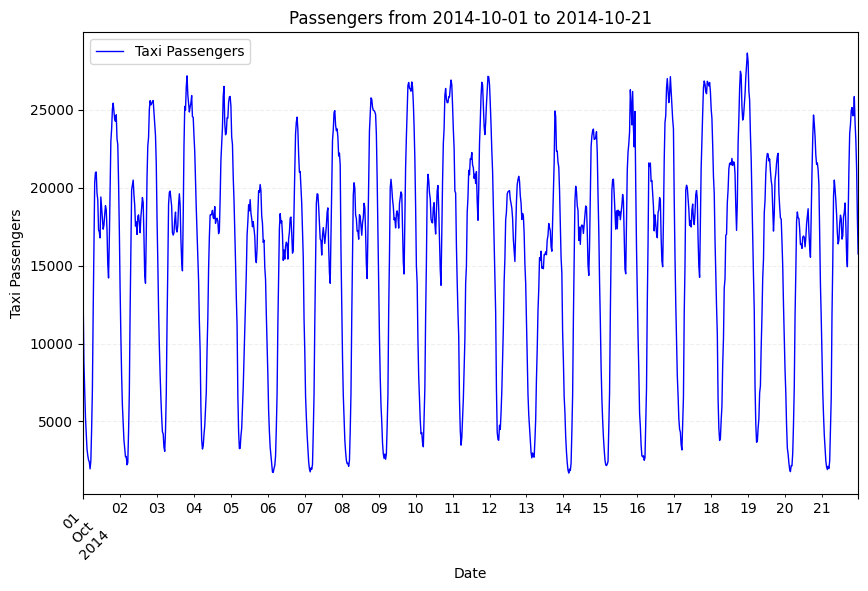

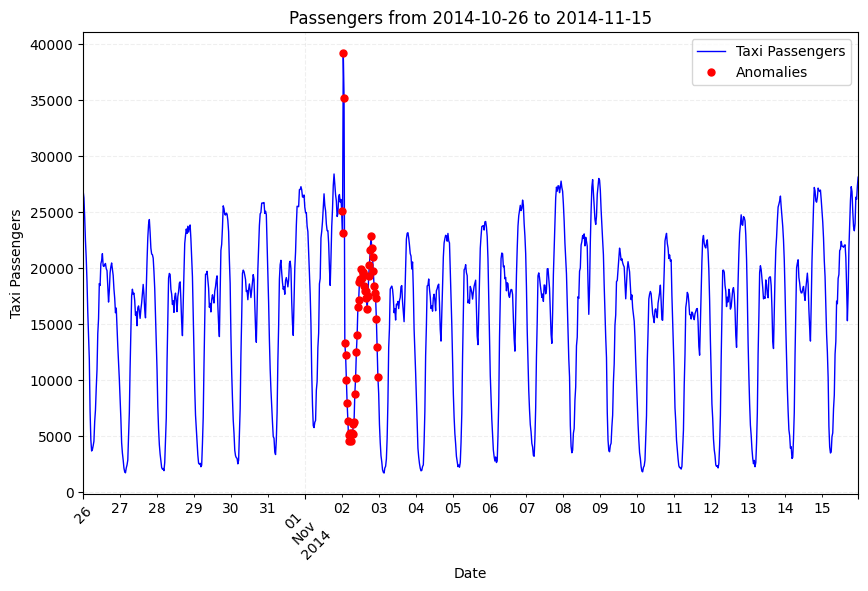

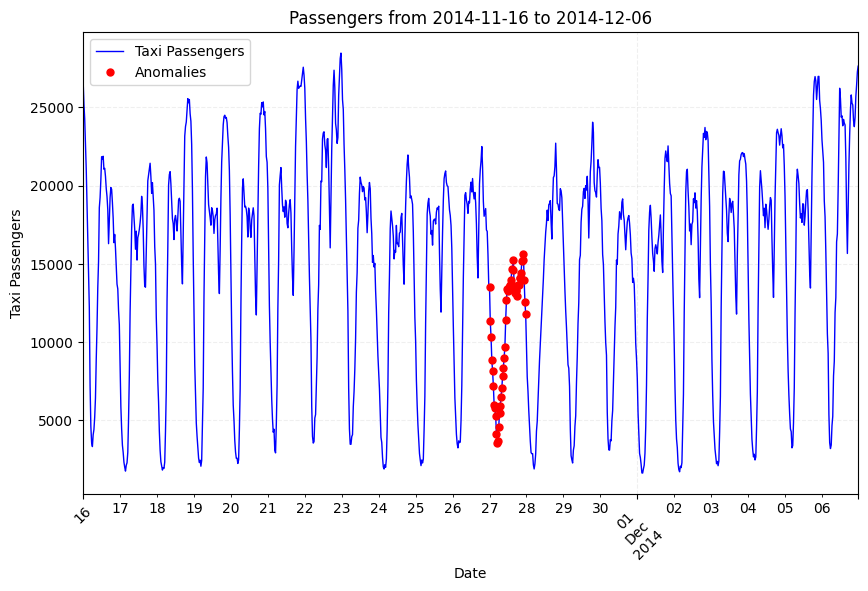

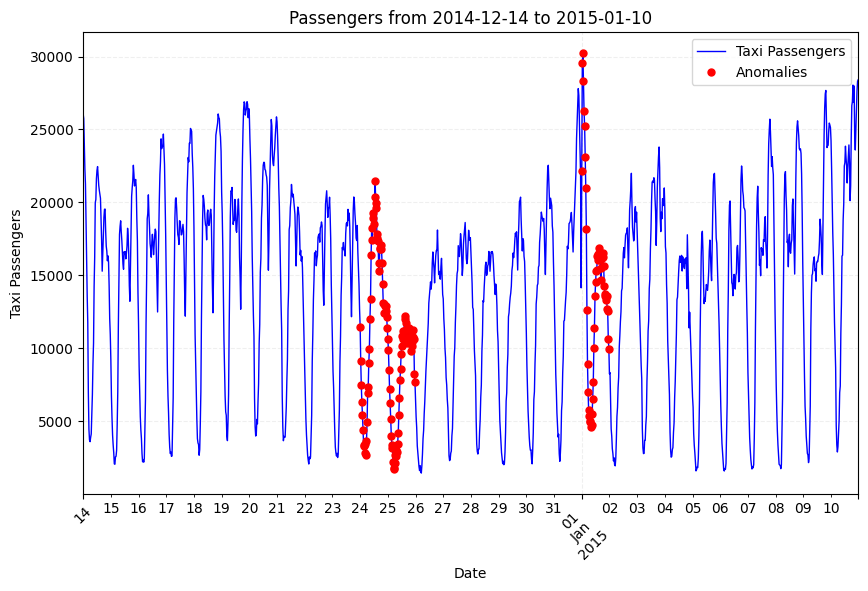

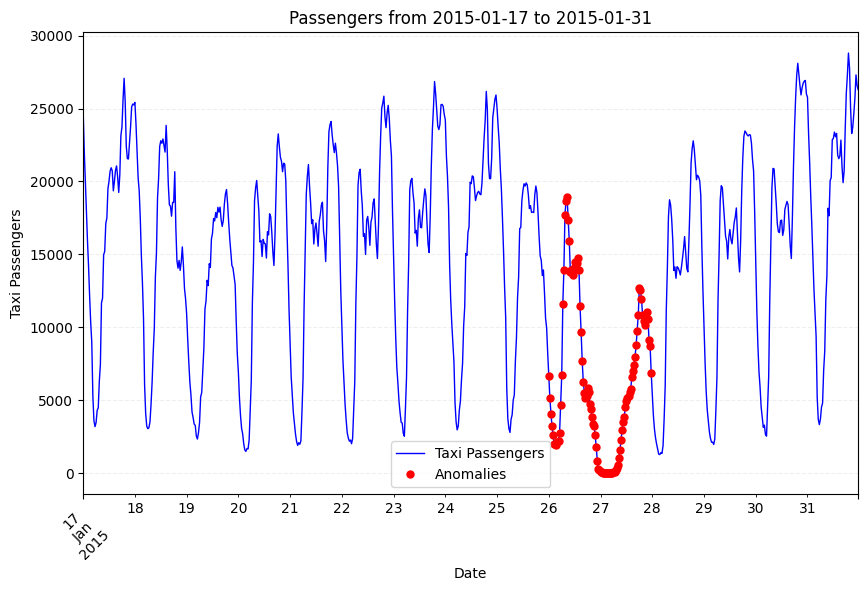

In [279]:
consicutive_weeks = [ 
        ['2014-10-01','2014-10-21'], # Normal
        ['2014-10-26','2014-11-15'], # Annual Marathon
        ['2014-11-16','2014-12-06'], # Thanksgiving
        ['2014-12-14','2015-01-10'], # Christmas and New Years
        ['2015-01-17','2015-01-31'] # Snowstorm
    ]
# Iterate over anomaly periods and plot
for interval in consicutive_weeks:
    make_graph(interval)

## Normal distribution checking

"value" feature are not in normal distribution

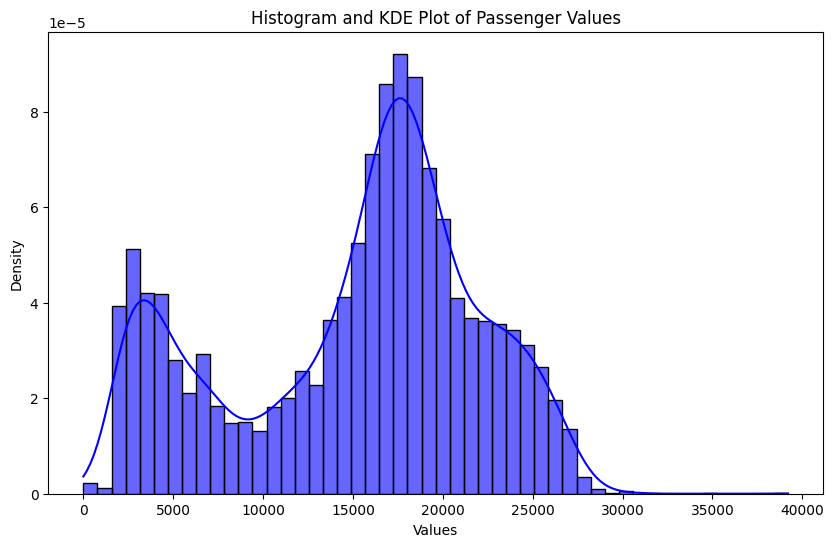

In [280]:
# Plot histogram with KDE (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.histplot(dataset['value'], kde=True, bins=50, color='blue', stat='density', alpha=0.6)
plt.title('Histogram and KDE Plot of Passenger Values')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

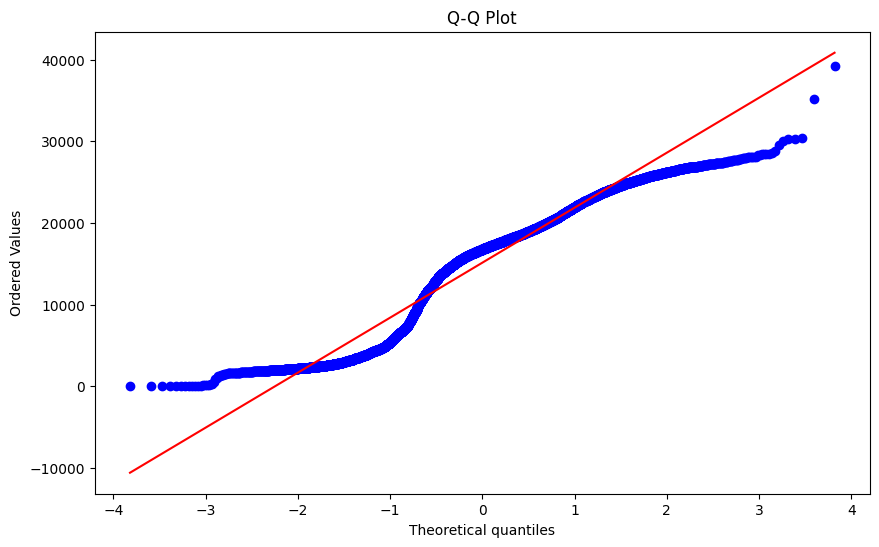

In [281]:
import scipy.stats as stats

# Generate Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(dataset['value'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()


## Lag Plots for Autocorrelation Checking

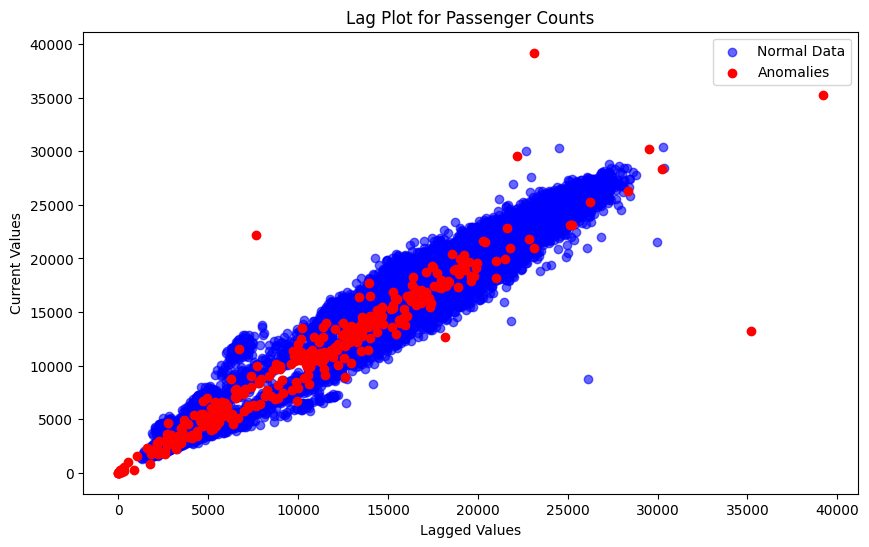

In [282]:
# Separate normal and anomaly data
normal_data = dataset[~dataset['isAnomaly']]  # Data without anomalies
anomaly_data = dataset[dataset['isAnomaly']]  # Data with anomalies

# Create lag plot
plt.figure(figsize=(10, 6))

# Plot normal data
plt.scatter(
    normal_data['value'][:-1],  # Lagging 'value'
    normal_data['value'][1:],   # Current 'value'
    color='blue', alpha=0.6, label='Normal Data'
)

# Plot anomaly data
plt.scatter(
    anomaly_data['value'][:-1],  # Lagging 'value'
    anomaly_data['value'][1:],   # Current 'value'
    color='red', label='Anomalies'
)

# Add plot title and legend
plt.title('Lag Plot for Passenger Counts')
plt.xlabel('Lagged Values')
plt.ylabel('Current Values')
plt.legend()

# Show the plot
plt.show()
